In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.tsv', 'test.tsv', 'sampleSubmission.csv']


In [23]:
#Import libraries
import numpy as np
import nltk
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

sb.set(color_codes=True)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
#Load the data
data_train = pd.read_csv("../input/train.tsv", sep="\t")
data_test = pd.read_csv("../input/test.tsv", sep='\t')
data_train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


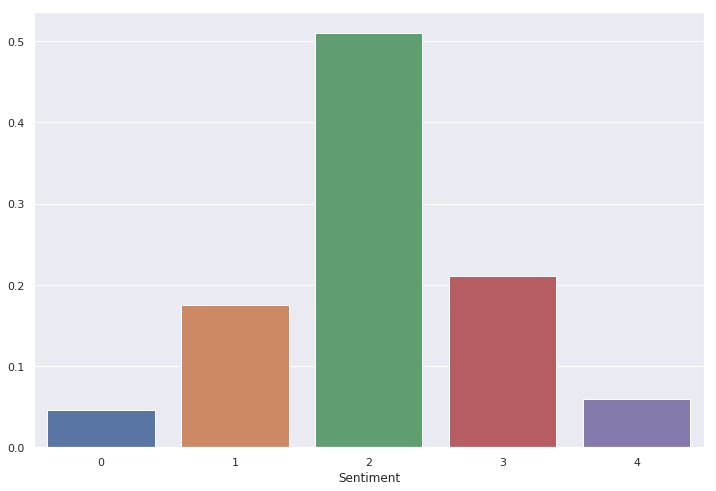

In [25]:
#Basic Visualisation of the data
dist = data_train.groupby(["Sentiment"]).size()
dist = dist / dist.sum()
plt.subplots(figsize=(12,8))
sb.barplot(dist.keys(), dist.values);

In [26]:
#Customized Tokenizer for data preprocessing
def NormalizingTokenizer(doc):
    #Tokenize
    phrase = nltk.word_tokenize(doc)
    #Lemmatize
    phrase_lemma = []
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for word in phrase:
        phrase_lemma.append(lemmatizer.lemmatize(word))
    #Handle negations
    phrase_iterator = iter(phrase_lemma)
    negation = False
    phrase_negated = []
    for word in phrase_iterator:
        phrase_negated.append(word)
        if word ==  'not':
            negation = True
            break 
    for word in phrase_iterator:
            phrase_negated.append('not_' + word) 
    return phrase_negated

In [27]:
#Building Pipelines

#Naive Bayes Classifier
bayes_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=NormalizingTokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
#Support Vector Machine Classifier
svm_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=NormalizingTokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),
])

In [28]:
# Normalize
def NormalizingTokenizer(doc):
    #Tokenize
    phrase = nltk.word_tokenize(doc)
    #Lemmatize
    phrase_lemma = []
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for word in phrase:
        phrase_lemma.append(lemmatizer.lemmatize(word))
    #Handle negations
    phrase_iterator = iter(phrase_lemma)
    negation = False
    phrase_negated = []
    for word in phrase_iterator:
        phrase_negated.append(word)
        if word ==  'not':
            negation = True
            break 
    for word in phrase_iterator:
            phrase_negated.append('not_' + word) 
    return phrase_negated

In [30]:
#In order to train the model on multiple cores, all functions need to be 'picklable'
#Because of this we have to import the NormalizingTokenizer function

#Naive Bayes Classifier pipeline with imported tokenizer
bayes_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=NormalizingTokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
#Support Vector Machine Classifier pipeline with imported tokenizer
svm_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=NormalizingTokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),
])

#Parameters range for the NB Model:
#Exlore the models for mono-, bi-, and tri-grams
#Explore with or without inverse document frequency
#Explore with alpha= 0.5 or 1.0
bayes_parameters = {
     'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
     'tfidf__use_idf': (True, False),     
     'clf__alpha': (0.5, 1.0),
}

#Parameters range for the SVM Model:
#Exlore the models for mono-, bi-, and tri-grams
#Explore with or without inverse document frequency
#Explore with alpha= 0.01 or 0.001
svm_parameters = {
     'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
     'tfidf__use_idf': (True, False),     
     'clf__alpha': (1e-2, 1e-3),
}

#Split the training set
X_train, X_validation, Y_train, Y_validation = train_test_split(data_train.values[:,2], 
                                                                data_train.values[:,-1].astype(int),
                                                                test_size=0.1)

In [ ]:
#Parameter search on NB Classifier for the first 10000 datapoints
gs_bayes = GridSearchCV(bayes_clf, bayes_parameters, cv=5, iid=False, n_jobs=-1, verbose=10)
gs_bayes.fit(X_train[:10000], Y_train[:10000])
#Fitting the model to the entire training dataset
bayes_clf = gs_bayes.best_estimator_
bayes_clf.fit(X_train, Y_train)
#Testing the model
predicted = bayes_clf.predict(X_validation)
print('NB Classifier:')
print(metrics.classification_report(Y_validation, predicted))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
